<a href="https://colab.research.google.com/github/Acquaye98/BLSTM-Densenet-fo-Sentiment-Analysis-Classification/blob/main/Copy_of_Loaded_BERT%2B_densenet_1st_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name() # this is to check the device name for CUDA. If not zero, change device number accordingly

'/device:GPU:0'

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.7 MB/s eta 0:00:00


In [ ]:
import torch
from torch import optim
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import re
import math

from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

import transformers
from transformers import BertModel, BertTokenizerFast
from transformers import AdamW, get_linear_schedule_with_warmup


import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cpu') #torch.device('cuda:0')
print(device)
#torch.multiprocessing.set_start_method('spawn')

import warnings
warnings.filterwarnings('ignore')
CUDA_LAUNCH_BLOCKING=1

cpu


In [ ]:
n = 8000 #number of samples MAx-> 49000
random_state = 42
EPOCHS = 5
sen_length = 512 #maximun length of tokens in a document (chosen based on distribution)

Pre_trained_model='bert-base-uncased'
batch_size=64

PATH = "SentimentBert-WithoutStopWordsUncasedRemoved@urlsDigits.pt" #saving best model with parameters

learning_rate = 2e-5
momentum = 0.5
log_interval = 10

In [ ]:
#for densnetnet model
LoadPath = '//content/gdrive/MyDrive/Harry/SentimentBert-WithoutStopWordsUncasedRemoved@urlsDigits.pt'
SavePath = '//content/gdrive/MyDrive/Harry/Bert12Layer + ResNet50-'+str(n)+'-WithoutStopWordsUncasedRemoved@urlsDigits.pt'

In [ ]:
import torch
import torch.nn as nn
from typing import Type, Union, List, Optional, Callable



PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.last = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.activ = torch.nn.Sigmoid()

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    output = self.last(output)

    return self.activ(output)

In [ ]:
import re
from collections import OrderedDict
from functools import partial
from typing import Any, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch import Tensor


__all__ = [
    "DenseNet",
    "DenseNet121_Weights",
    "DenseNet161_Weights",
    "DenseNet169_Weights",
    "DenseNet201_Weights",
    "densenet121",
    "densenet161",
    "densenet169",
    "densenet201",
]


class _DenseLayer(nn.Module):
    def __init__(
        self, num_input_features: int, growth_rate: int, bn_size: int, drop_rate: float, memory_efficient: bool = False
    ) -> None:
        super().__init__()
        self.norm1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)

        self.norm2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)

        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs: List[Tensor]) -> Tensor:
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input: List[Tensor]) -> bool:
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input: List[Tensor]) -> Tensor:
        def closure(*inputs):
            return self.bn_function(inputs)

        return cp.checkpoint(closure, *input)

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: List[Tensor]) -> Tensor:  # noqa: F811
        pass

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: Tensor) -> Tensor:  # noqa: F811
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input: Tensor) -> Tensor:  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(
        self,
        num_layers: int,
        num_input_features: int,
        bn_size: int,
        growth_rate: int,
        drop_rate: float,
        memory_efficient: bool = False,
    ) -> None:
        super().__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module("denselayer%d" % (i + 1), layer)

    def forward(self, init_features: Tensor) -> Tensor:
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features: int, num_output_features: int) -> None:
        super().__init__()
        self.norm = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.

    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """

    def __init__(
        self,
        growth_rate: int = 32,
        block_config: Tuple[int, int, int, int] = (6, 12, 24, 16),
        num_init_features: int = 64,
        bn_size: int = 4,
        drop_rate: float = 0,
        num_classes: int = 1,
        memory_efficient: bool = False,
    ) -> None:

        super().__init__()
        #_log_api_usage_once(self)

        # First convolution
        self.features = nn.Sequential(
            OrderedDict(
                [
                    ("conv0", nn.Conv2d(1, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
                    ("norm0", nn.BatchNorm2d(num_init_features)),
                    ("relu0", nn.ReLU(inplace=True)),
                    ("pool0", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
                ]
            )
        )

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.features.add_module("denseblock%d" % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module("transition%d" % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module("norm5", nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return torch.sigmoid(out)


def _load_state_dict(model: nn.Module, weights: None, progress: bool) -> None:
    # '.'s are no longer allowed in module names, but previous _DenseLayer
    # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
    # They are also in the checkpoints in model_urls. This pattern is used
    # to find such keys.
    pattern = re.compile(
        r"^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$"
    )

    state_dict = weights.get_state_dict(progress=progress, check_hash=True)
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    model.load_state_dict(state_dict)


def _densenet(
    growth_rate: int,
    block_config: Tuple[int, int, int, int],
    num_init_features: int,
    weights: None,
    progress: bool,
    **kwargs: Any,
) -> DenseNet:


    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)

    if weights is not None:
        _load_state_dict(model=model, weights=weights, progress=progress)

    return model



def densenet121(*, weights = None, progress: bool = True, **kwargs: Any) -> DenseNet:
    r"""Densenet-121 model from
    `Densely Connected Convolutional Networks <https://arxiv.org/abs/1608.06993>`_.

    Args:
        weights (:class:`~torchvision.models.DenseNet121_Weights`, optional): The
            pretrained weights to use. See
            :class:`~torchvision.models.DenseNet121_Weights` below for
            more details, and possible values. By default, no pre-trained
            weights are used.
        progress (bool, optional): If True, displays a progress bar of the download to stderr. Default is True.
        **kwargs: parameters passed to the ``torchvision.models.densenet.DenseNet``
            base class. Please refer to the `source code
            <https://github.com/pytorch/vision/blob/main/torchvision/models/densenet.py>`_
            for more details about this class.

    .. autoclass:: torchvision.models.DenseNet121_Weights
        :members:
    """
    weights = None

    return _densenet(32, (1, 1, 1, 1), 64, weights, progress, **kwargs)



In [ ]:
from transformers import BertModel

BertModel = SentimentClassifier(1)
optimizer = AdamW(BertModel.parameters(), lr=learning_rate, correct_bias=False)

checkpoint = torch.load(LoadPath,map_location=device)
BertModel.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

BertModel.eval()
BertModel.to(device)

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
#THIS IS A HOOK CREATED TO EXTRACT OUTPUT OF BERT LAST ENCODER OUTPUT
def get_features(name):
    def hook(BertModel, input, output):
        features[name] = output.detach()
    return hook
BertModel.bert.encoder.layer[11].output.register_forward_hook(get_features('feats'))
features = {}

In [ ]:
#Dataset
df = pd.read_csv("//content/gdrive/MyDrive/Harry/IMDB Dataset test.csv",
                names=['review', 'sentiment'],
                header=0,
                encoding='latin-1')

#print(df.describe())

df=df.rename(columns = {'review' : 'text', 'sentiment':'polarity'})
#print(df.describe())
#df = df.drop(columns=['id', 'date', 'query', 'user'])
df.polarity = df.polarity.replace({'negative': 0, 'positive': 1})

class_names = ['negative', 'positive']

#Entire dataset
print(df.polarity.value_counts())
print(df.polarity.unique())

1    25000
0    25000
Name: polarity, dtype: int64
[1 0]


In [ ]:
#pre processing

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text)).strip() #lower case
  tokens = []
  for token in text.split():
    tokens.append(token)
  return " ".join(tokens)

df.text = df.text.apply(lambda x: preprocess(x))

#Train-validate-test sets
df_train,df_test=train_test_split(df, test_size=0.02, random_state=random_state)

df_train = df_train.sample(n=n,random_state=random_state) #choosing subsample
df_train,df_valid = train_test_split(df_train,test_size=0.1,random_state=random_state)


print('Print the shape of datasets...')
print(f'Testing dataset : {df_test.shape}')
print(f'Training dataset : {df_train.shape}')
print(f'Validation dataset : {df_valid.shape}')

Print the shape of datasets...
Testing dataset : (1000, 2)
Training dataset : (7200, 2)
Validation dataset : (800, 2)


In [ ]:
#Dataset class
class imdb_sentiment(Dataset):

  def __init__(self,reviews,targets,tokenizer,sen_length):
    self.reviews=reviews
    self.targets=targets
    self.tokenizer=tokenizer
    self.sen_length=sen_length

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self,item):
    review = str(self.reviews[item])
    targets = self.targets[item]

    encoding = self.tokenizer.encode_plus(
        review,
        max_length=sen_length,
        add_special_tokens=True,
        pad_to_max_length=True,
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt'
       )
    input_ids = encoding['input_ids'].flatten().reshape([1,sen_length]).to(device)
    attention_mask = encoding['attention_mask'].flatten().reshape([1,sen_length]).to(device)

    BertModel(
        input_ids=input_ids,
        attention_mask=attention_mask)
    return {'review_text': review,
      'contextualised_embedding': features['feats'].flatten().view(1,sen_length,768).cpu().numpy(),
      'target': targets
    }


In [ ]:
print(BertModel)

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
#Dataloader Class
def data_loader(df, tokenizer, sen_length, batch):
  ds=imdb_sentiment(
      reviews=df.text.to_numpy(),
      targets=df.polarity.to_numpy(dtype=int),
      tokenizer=tokenizer,
      sen_length=sen_length
  )

  return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=0
  ) #num_workers 2 is efficient read https://deeplizard.com/learn/video/kWVgvsejXsE


tokenizer=BertTokenizerFast.from_pretrained(Pre_trained_model)

# Load datasets
train_DataLoader=data_loader(df_train,tokenizer,sen_length,batch_size)
test_DataLoader=data_loader(df_test,tokenizer,sen_length,batch_size)
valid_DataLoader=data_loader(df_valid,tokenizer,sen_length,batch_size)

In [ ]:
data = next(iter(train_DataLoader))
print(data.keys())

dict_keys(['review_text', 'contextualised_embedding', 'target'])


In [ ]:
#from pytorch_model_summary import summary
#print(summary(ResNet50(), data['contextualised_embedding'], show_input=True, max_depth=3, show_hierarchical=False,print_summary=True))


In [ ]:
np.shape(data['contextualised_embedding'])

torch.Size([64, 1, 512, 768])

In [ ]:
#model = CustomDenseNet()
model = densenet121()
model = model.to(device)
print(model)
optimizer = AdamW(model.parameters(), lr=learning_rate, correct_bias=False)
total_steps = len(train_DataLoader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.BCELoss().to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (transition1): _Transition(
      (norm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    contextualised_embedding = d["contextualised_embedding"].to(device)
    targets = d["target"].to(device)

    outputs = model(
      contextualised_embedding
    )
    preds = torch.round(outputs.view(-1))

    loss = F.binary_cross_entropy(outputs.view(-1), targets.float())
    #print(outputs,preds)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            contextualised_embedding = d["contextualised_embedding"].to(device)
            targets = d["target"].to(device)

            outputs = model(contextualised_embedding)
            preds = torch.round(outputs.view(-1))

            loss = F.binary_cross_entropy(outputs.view(-1), targets.float())

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
    model,
    train_DataLoader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
    model,
    valid_DataLoader,
    loss_fn,
    device,
    len(df_valid)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc.cpu())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.cpu())
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        print('saving best model')
        torch.save({
                'epoch': EPOCHS,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,
                }, SavePath)

Epoch 1/5
----------
Train loss 0.30285046928751785 accuracy 0.9591666666666666
Val   loss 0.18182240426540375 accuracy 0.985

saving best model
Epoch 2/5
----------
Train loss 0.17332432036642478 accuracy 0.9876388888888888
Val   loss 0.1463826562349613 accuracy 0.9875

saving best model
Epoch 3/5
----------
Train loss 0.1506282716198305 accuracy 0.9877777777777778
Val   loss 0.13390946502868945 accuracy 0.98625

Epoch 4/5
----------
Train loss 0.14083838423268985 accuracy 0.9875
Val   loss 0.13012812229303214 accuracy 0.98625

Epoch 5/5
----------
Train loss 0.13645979893946014 accuracy 0.9883333333333333
Val   loss 0.12888404383109167 accuracy 0.9875

CPU times: user 1d 2h 30min 25s, sys: 2h 53min 23s, total: 1d 5h 23min 49s
Wall time: 7h 30min 44s


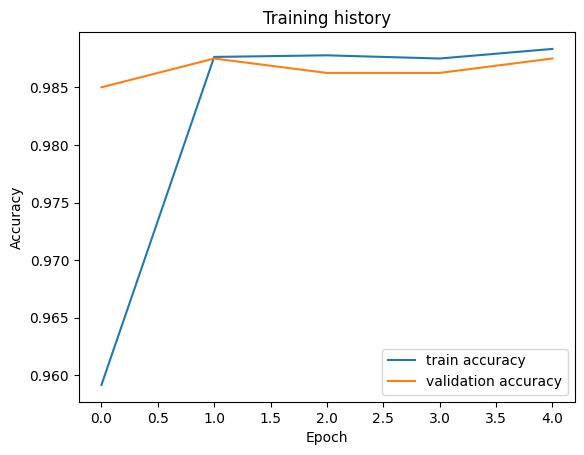

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_DataLoader,
  loss_fn,
  device,
  len(df_test)
)

print("Accuracy before model.save")
test_acc.item()

Accuracy before model.save


0.936

In [ ]:
# load best model
Load_model = densenet121()
Load_optimizer = AdamW(Load_model.parameters(), lr=learning_rate, correct_bias=False)

checkpoint = torch.load(SavePath)
Load_model.load_state_dict(checkpoint['model_state_dict'])
Load_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
Load_epoch = checkpoint['epoch']
Load_loss = checkpoint['loss']

Load_model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (transition1): _Transition(
      (norm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu)

In [ ]:

#For evaluting on a loaded data
# Load_model.to(device)
# test_acc, _ = eval_model(
#   Load_model,
#   test_DataLoader,
#   Load_loss,
#   device,
#   len(df_test)
# )
# print("Accuracy after loading model from path")
# test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      contextualised_embedding = d["contextualised_embedding"].to(device)
      targets = d["target"].to(device)

      outputs = model(contextualised_embedding)

      preds = torch.round(outputs.view(-1))
      loss = F.binary_cross_entropy(outputs.view(-1), targets.float())

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  Load_model,
  test_DataLoader
)

In [ ]:
print("sentence length", sen_length)
print("dataset size", n)
print("batch size", 2)
print(classification_report(y_test, y_pred, target_names=class_names,digits=4))

sentence length 512
dataset size 8000
batch size 2
              precision    recall  f1-score   support

    negative     0.9485    0.9141    0.9310       524
    positive     0.9091    0.9454    0.9269       476

    accuracy                         0.9290      1000
   macro avg     0.9288    0.9298    0.9289      1000
weighted avg     0.9297    0.9290    0.9290      1000



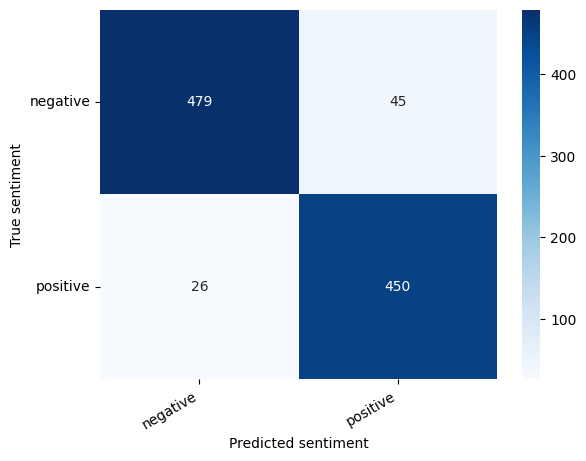

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)